In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from datetime import datetime 
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sklearn.metrics import roc_curve,auc

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [3]:
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import keras 
import keras.backend as K

In [4]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [5]:
def roccurve(y_test,y_prob):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    plt.figure(figsize=(10,10))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],linestyle='--')
    plt.axis('tight')
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

In [6]:
def onedarray1(thrs,y_pred):
    y_pred1d=[]
    for i,y in enumerate(y_pred):
        if y[1] >= thrs:
            y_pred1d.append([1])

        else:
            y_pred1d.append([0])
    return y_pred1d

In [39]:
def accrecallthrs(y_test,y_pred):
    evaluate_results = []
    for threshold in np.arange(0, 1.01, 0.01):
        tp , tn , fp ,fn = 0 , 0 , 0, 0
        for i,y in enumerate(y_pred):
            if y[1] >= threshold and y_test[i] == 1:
                tp+=1
            elif y[1] >= threshold and y_test[i] == 0:
                fp += 1
            elif y[1] < threshold and y_test[i] == 1:
                fn += 1
            elif y[1] < threshold and y_test[i] == 0:
                tn += 1
        result = dict()
        result['threshold'] = threshold
        result['TP'] = tp
        result['FP'] = fp
        result['FN'] = fn
        result['TN'] = tn
        result['recall'] = tp / (tp + fn)
        #result['precision'] = tp / (tp + fp)
        result['accuracy'] = (tp + tn) / (tp + fn + fp + tn)
        evaluate_results.append(result)
    
    threshold_array = [result['threshold'] for result in evaluate_results]
    recall_array = [result['recall'] for result in evaluate_results]
    #precision_array = [result['precision'] for result in evaluate_results]
    accuracy_array = [result['accuracy'] for result in evaluate_results]
    plt.plot(threshold_array, recall_array, label='recall')
    #plt.plot(threshold_array, precision_array, label='precision')
    plt.plot(threshold_array, accuracy_array, label='accuracy')
    plt.xlabel('Threshold 0~1')
    plt.ylabel('recall & precision & accuracy')
    plt.legend()
    plt.show()
        

In [8]:
data=pd.read_csv('../input/creditcardfraud/creditcard.csv')

In [9]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
data.isnull().sum().max()

0

In [11]:
data.shape
b=data.shape[0]

In [12]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
data.shape

(284807, 31)

In [15]:
data.drop_duplicates(subset=data.columns.values[:-1], keep='first',inplace=True)
print(b-data.shape[0]," duplicated Rows has been removed")

1081  duplicated Rows has been removed


In [16]:
data.shape

(283726, 31)

0    283253
1       473
Name: Class, dtype: int64


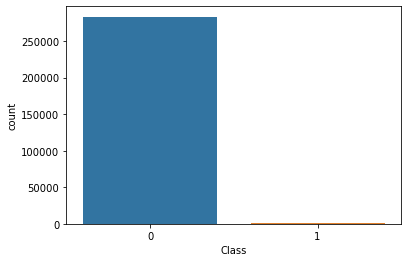

In [17]:
# Class count
print(data['Class'].value_counts())
sns.countplot(data=data, x='Class')

In [18]:
normal_df = data[data['Class']==0]
fraud_df = data[data['Class']==1]

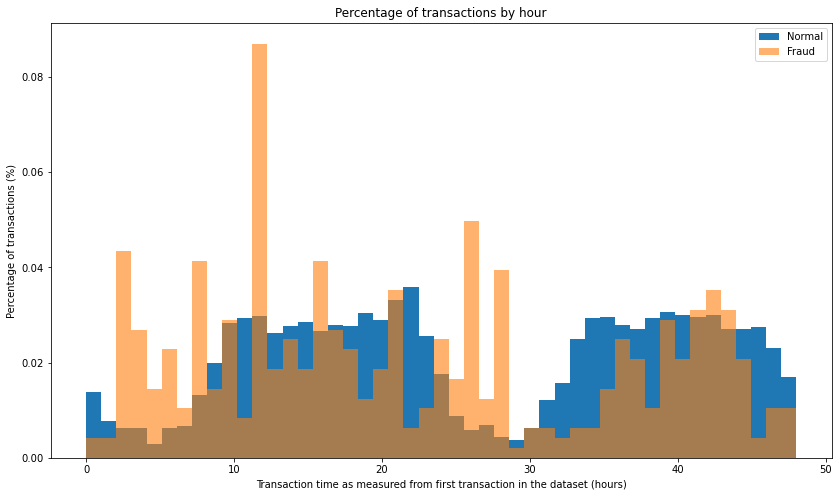

In [19]:
bins = np.linspace(0, 48, 48) #48 hours
plt.figure(figsize=(14, 8))
plt.hist((normal_df.Time/(60*60)), bins, alpha=1, density=True, label='Normal')
plt.hist((fraud_df.Time/(60*60)), bins, alpha=0.6, density=True, label='Fraud')
plt.legend(loc='upper right')
plt.title("Percentage of transactions by hour")
plt.xlabel("Transaction time as measured from first transaction in the dataset (hours)")
plt.ylabel("Percentage of transactions (%)");
# plt.hist((df.Time/(60*60)),bins)
plt.show()

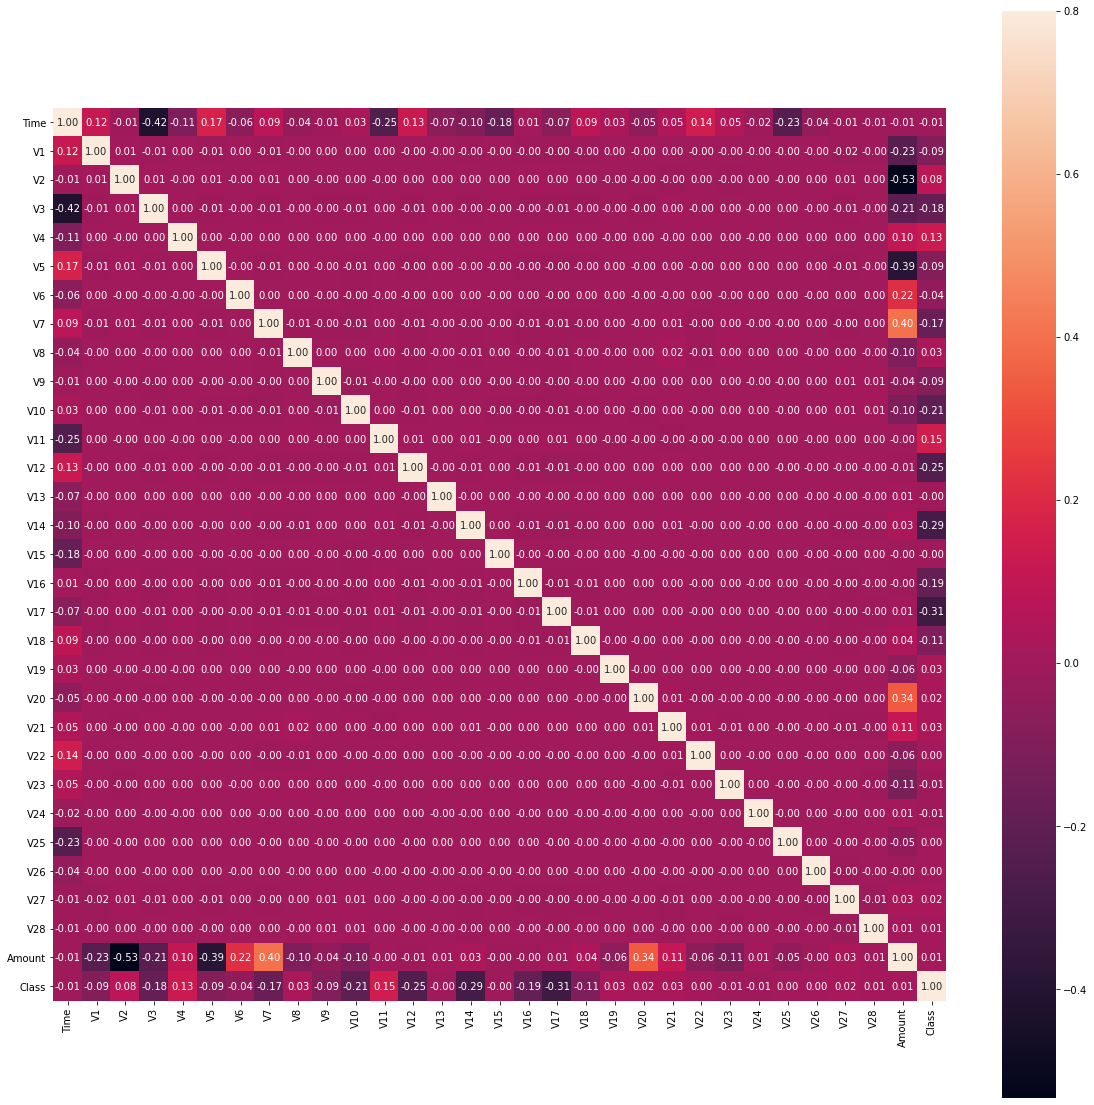

In [20]:
plt.subplots(figsize=(20,20))
sns.heatmap(data.corr(), vmax=.8 , square=True,annot=True,fmt='.2f')

In [21]:
data.corr().nlargest(31,'Class')['Class']

Class     1.000000
V11       0.149067
V4        0.129326
V2        0.084624
V19       0.033631
V8        0.033068
V21       0.026357
V27       0.021892
V20       0.021486
V28       0.009682
Amount    0.005777
V22       0.004887
V26       0.004265
V25       0.003202
V15      -0.003300
V13      -0.003897
V23      -0.006333
V24      -0.007210
Time     -0.012359
V6       -0.043915
V5       -0.087812
V9       -0.094021
V1       -0.094486
V18      -0.105340
V7       -0.172347
V3       -0.182322
V16      -0.187186
V10      -0.206971
V12      -0.250711
V14      -0.293375
V17      -0.313498
Name: Class, dtype: float64

data['Amount'].to_numpy(dtype=np.ndarray).reshape(-1,1).shape

In [22]:
from sklearn.preprocessing import StandardScaler
data['Amount'] = StandardScaler().fit_transform(data['Amount'].to_numpy(dtype=np.ndarray).reshape(-1,1))
data = data.drop(['Time'], axis=1)
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244200,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342584,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.158900,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.139886,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073813,0


X = data.iloc[:, data.columns != 'Class']
y = data.iloc[:, data.columns == 'Class']

In [23]:
X = np.array(data.iloc[:, data.columns != 'Class'])
y = np.array(data.iloc[:, data.columns == 'Class'])

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=40, shuffle =True)

# **OVERSAMPLING DATASET**

In [25]:
from imblearn.over_sampling import SMOTE #Over sampling
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel())

In [26]:
y_train_res = pd.DataFrame(data=y_train_res,columns=['Class'])

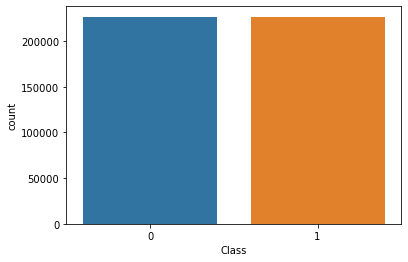

In [27]:
sns.countplot(x='Class', data=y_train_res)

In [28]:
y_train_res.value_counts()

Class
1        226600
0        226600
dtype: int64

In [29]:
#df = pd.DataFrame(X_train)
row,col = X_train_res.shape

# **ADDING GAUSSIAN NOISE (MEAN = 0 )**

In [30]:
#ADDING GAUSSIAN NOISE (MEAN = 0 , SD= 1)
X_train_noise= X_train_res
for i,x in enumerate(X_train_res):
    noise  = np.random.normal(0,0.02,[col])
    X_train_noise[i] += noise

# **AUTO_ENCODER**

In [31]:
# This returns a tensor
input_layer = Input(shape=(col, ))
encoder = Dense(22, activation="relu")(input_layer)
encoder = Dense(15, activation="relu")(encoder)
encoder = Dense(10, activation="relu")(encoder)
decoder = Dense(15, activation='relu')(encoder)
decoder = Dense(22, activation='relu')(decoder)
decoder = Dense(29, activation='relu')(decoder)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder = Model(inputs=input_layer, outputs=decoder)

# **LOSS_FUNCTION**

In [32]:
def lossfunc(y_true,y_pred):
    cost =  tf.reduce_mean(tf.square(tf.subtract(y_pred, y_true)))
    
    return cost

# **TRAINING AUTOENCODER WITH NOISY DATA**

In [33]:
model_opt=keras.optimizers.Adam(0.00001)
autoencoder.compile(optimizer=model_opt,loss=lossfunc)
autoencoder.fit(x=X_train_noise,y=X_train_res,epochs=40,batch_size = 100,shuffle=True)

Epoch 1/40
4532/4532 [==============================] - 8s 2ms/step - loss: 11.5247
Epoch 2/40
4532/4532 [==============================] - 7s 2ms/step - loss: 11.1544
Epoch 3/40
4532/4532 [==============================] - 7s 2ms/step - loss: 11.1023
Epoch 4/40
4532/4532 [==============================] - 7s 2ms/step - loss: 11.0664
Epoch 5/40
4532/4532 [==============================] - 7s 2ms/step - loss: 11.0336
Epoch 6/40
4532/4532 [==============================] - 7s 2ms/step - loss: 11.0033
Epoch 7/40
4532/4532 [==============================] - 7s 2ms/step - loss: 10.9787
Epoch 8/40
4532/4532 [==============================] - 7s 1ms/step - loss: 10.9504
Epoch 9/40
4532/4532 [==============================] - 6s 1ms/step - loss: 10.9267
Epoch 10/40
4532/4532 [==============================] - 7s 1ms/step - loss: 10.9066
Epoch 11/40
4532/4532 [==============================] - 7s 1ms/step - loss: 10.8862
Epoch 12/40
4532/4532 [==============================] - 7s 1ms/step - los

In [34]:
autoencoder.trainable = False

# **NEURAL NETWORK CLASSIFIER**

In [35]:
classifier = Dense(22, activation="relu")(autoencoder.output)
classifier = Dense(15, activation="relu")(classifier)
classifier = Dense(10, activation="relu")(classifier)
classifier = Dense(5, activation='relu')(classifier)
classifier = Dense(2, activation='softmax')(classifier)
classmodel = Model(inputs=autoencoder.input,outputs=classifier)
classmodel.compile(optimizer=keras.optimizers.Adam(0.01),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classmodel.fit(x=X_train_noise,y=y_train_res,epochs=15,batch_size = 32,shuffle=True)

Epoch 1/15
14163/14163 [==============================] - 22s 2ms/step - loss: 0.0987 - accuracy: 0.9581
Epoch 2/15
14163/14163 [==============================] - 21s 1ms/step - loss: 0.0704 - accuracy: 0.9727
Epoch 3/15
14163/14163 [==============================] - 20s 1ms/step - loss: 0.0630 - accuracy: 0.9761
Epoch 4/15
14163/14163 [==============================] - 21s 1ms/step - loss: 0.0589 - accuracy: 0.9780
Epoch 5/15
14163/14163 [==============================] - 21s 1ms/step - loss: 0.0561 - accuracy: 0.9793
Epoch 6/15
14163/14163 [==============================] - 21s 2ms/step - loss: 0.0530 - accuracy: 0.9805
Epoch 7/15
14163/14163 [==============================] - 20s 1ms/step - loss: 0.0519 - accuracy: 0.9811
Epoch 8/15
14163/14163 [==============================] - 21s 1ms/step - loss: 0.0498 - accuracy: 0.9819
Epoch 9/15
14163/14163 [==============================] - 20s 1ms/step - loss: 0.0483 - accuracy: 0.9824
Epoch 10/15
14163/14163 [==============================

1774/1774 [==============================] - 2s 1ms/step - loss: 0.0748 - accuracy: 0.9752
[0.07479079812765121, 0.9751524329185486]


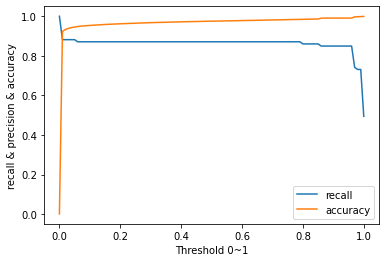

[[55255  1398]
 [   12    81]]



Classification report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56653
           1       0.05      0.87      0.10        93

    accuracy                           0.98     56746
   macro avg       0.53      0.92      0.55     56746
weighted avg       1.00      0.98      0.99     56746



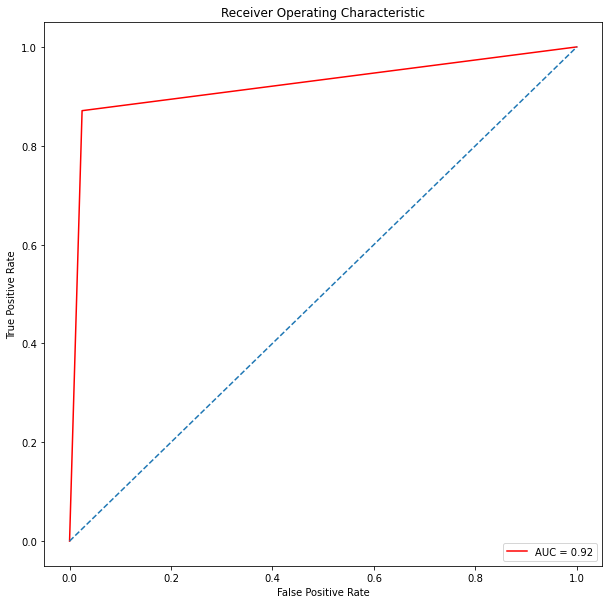

In [36]:
print(classmodel.evaluate(X_test,y_test))
y_pred=classmodel.predict(X_test)
accrecallthrs(y_test,y_pred)
y_pred=onedarray1(0.5,y_pred)
print(confusion_matrix(y_test,y_pred))
print("\n\n")
print("Classification report \n {0}".format(classification_report(y_test, y_pred)))
roccurve(y_test,y_pred)

# **NEURAL NETWORK CLASSIFIER WITH MORE HIDDEN LAYERS**

In [37]:
classifierde = Dense(22, activation="relu")(autoencoder.output)
classifierde = Dense(19, activation="relu")(classifierde)
classifierde = Dense(15, activation="relu")(classifierde)
classifierde = Dense(12, activation="relu")(classifierde)
classifierde = Dense(10, activation="relu")(classifierde)
classifierde = Dense(7, activation="relu")(classifierde)
classifierde = Dense(4, activation='relu')(classifierde)
classifierde = Dense(2, activation='softmax')(classifierde)
classmodelde = Model(inputs=autoencoder.input,outputs=classifierde)
classmodelde.compile(optimizer=keras.optimizers.Adam(0.01),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

classmodelde.fit(x=X_train_noise,y=y_train_res,epochs=15,batch_size = 32,shuffle=True)

Epoch 1/15
14163/14163 [==============================] - 24s 2ms/step - loss: 0.1004 - accuracy: 0.9585
Epoch 2/15
14163/14163 [==============================] - 24s 2ms/step - loss: 0.0726 - accuracy: 0.9712
Epoch 3/15
14163/14163 [==============================] - 25s 2ms/step - loss: 0.0647 - accuracy: 0.9751
Epoch 4/15
14163/14163 [==============================] - 26s 2ms/step - loss: 0.0677 - accuracy: 0.9757
Epoch 5/15
14163/14163 [==============================] - 24s 2ms/step - loss: 0.0695 - accuracy: 0.9763
Epoch 6/15
14163/14163 [==============================] - 23s 2ms/step - loss: 0.0743 - accuracy: 0.9751
Epoch 7/15
14163/14163 [==============================] - 23s 2ms/step - loss: 0.0756 - accuracy: 0.9758
Epoch 8/15
14163/14163 [==============================] - 32s 2ms/step - loss: 0.0829 - accuracy: 0.9760
Epoch 9/15
14163/14163 [==============================] - 22s 2ms/step - loss: 0.0786 - accuracy: 0.9766
Epoch 10/15
14163/14163 [==============================

1774/1774 [==============================] - 2s 1ms/step - loss: 0.1216 - accuracy: 0.9614
[0.12156379967927933, 0.961442232131958]


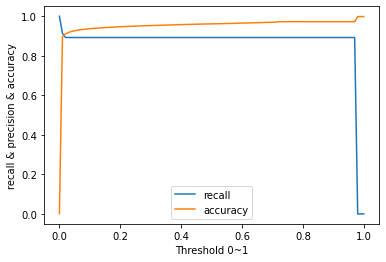

[[54475  2178]
 [   10    83]]



Classification report 
               precision    recall  f1-score   support

           0       1.00      0.96      0.98     56653
           1       0.04      0.89      0.07        93

    accuracy                           0.96     56746
   macro avg       0.52      0.93      0.53     56746
weighted avg       1.00      0.96      0.98     56746



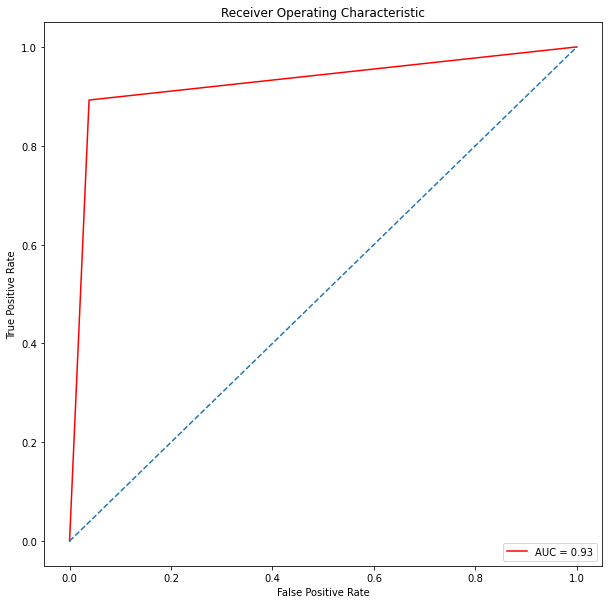

In [40]:
print(classmodelde.evaluate(X_test,y_test))
y_predde=classmodelde.predict(X_test)
accrecallthrs(y_test,y_predde)
y_predde=onedarray1(0.5,y_predde)
print(confusion_matrix(y_test,y_predde))
print("\n\n")
print("Classification report \n {0}".format(classification_report(y_test, y_predde)))
roccurve(y_test,y_predde)

# **NEURAL NETWORK CLASSIFIER WITH MEAN SQUARE LOSS**

In [41]:
classifier1 = Dense(22, activation="relu")(autoencoder.output)
classifier1 = Dense(15, activation="relu")(classifier1)
classifier1 = Dense(10, activation="relu")(classifier1)
classifier1 = Dense(5, activation='relu')(classifier1)
classifier1 = Dense(2, activation='softmax')(classifier1)
classmodel_mse = Model(inputs=autoencoder.input,outputs=classifier1)
classmodel_mse.compile(optimizer=keras.optimizers.Adam(0.001),
                   loss='mse',
                   metrics=['accuracy'])

In [42]:
y_train2d = []
arr = np.array(y_train_res)
for i in range(y_train_res.shape[0]):
    if  arr[i] == 0:
        y_train2d.append([1,0])
    else:
        y_train2d.append([0,1])
y_train2d = pd.DataFrame(y_train2d)

In [43]:
classmodel_mse.fit(x=X_train_noise,y=y_train2d,epochs=15,batch_size = 100,shuffle=True)

Epoch 1/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0369 - accuracy: 0.9525
Epoch 2/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0233 - accuracy: 0.9697
Epoch 3/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0201 - accuracy: 0.9743
Epoch 4/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0182 - accuracy: 0.9767
Epoch 5/15
4532/4532 [==============================] - 7s 2ms/step - loss: 0.0167 - accuracy: 0.9789
Epoch 6/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0156 - accuracy: 0.9805
Epoch 7/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0150 - accuracy: 0.9813
Epoch 8/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.0145 - accuracy: 0.9820
Epoch 9/15
4532/4532 [==============================] - 7s 2ms/step - loss: 0.0139 - accuracy: 0.9827
Epoch 10/15
4532/4532 [==============================] - 8s 2ms/step - loss: 0.013

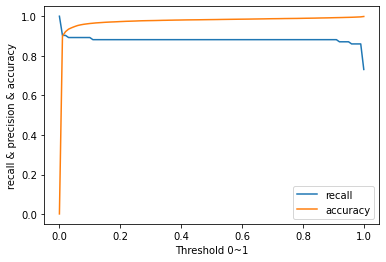

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.99      1.00     56653
           1       0.17      0.88      0.28        93

    accuracy                           0.99     56746
   macro avg       0.58      0.94      0.64     56746
weighted avg       1.00      0.99      1.00     56746



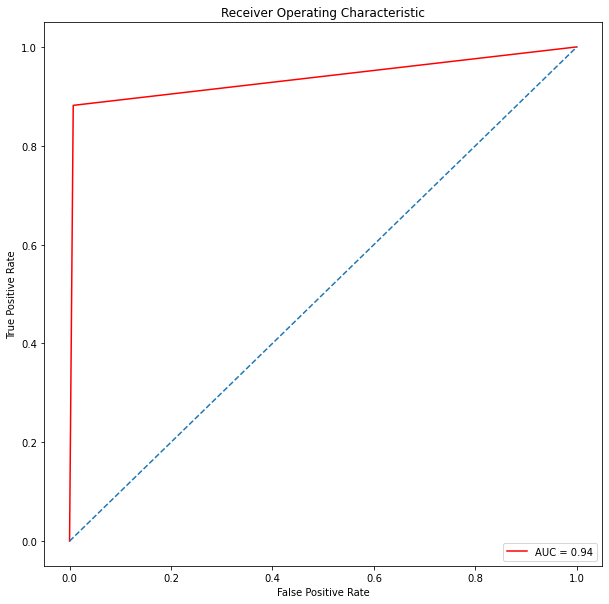

In [44]:
y_predmse=classmodel_mse.predict(X_test)
accrecallthrs(y_test,y_predmse)
y_predmse = onedarray1(0.9,y_predmse)
print("Classification report \n {0}".format(classification_report(y_test, y_predmse)))
roccurve(y_test, y_predmse)

In [45]:
X_train_enc = autoencoder.predict(X_train_res)

In [46]:
y_train1 = []
arr = np.array(y_train_res)
for i in range(y_train_res.shape[0]):
    if  arr[i] == 0:
        y_train1.append(0)
    else:
        y_train1.append(1)


# **KNN CLASSIFIER WITH INPUT FROM AUTO ENCODER**

In [47]:
knn=KNeighborsClassifier(n_neighbors=5,n_jobs=-1)
knn.fit(X_train_enc,y_train1)

KNeighborsClassifier(n_jobs=-1)

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     56653
           1       0.06      0.82      0.11        93

    accuracy                           0.98     56746
   macro avg       0.53      0.90      0.55     56746
weighted avg       1.00      0.98      0.99     56746



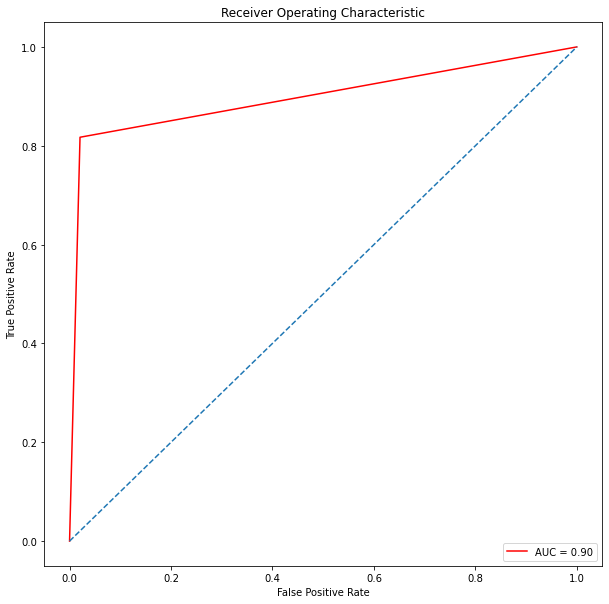

In [48]:
predknn=knn.predict(X_test)
print("Classification report \n {0}".format(classification_report(y_test, predknn)))
roccurve(y_test, predknn)

# **RANDOM FOREST CLASSIFIER WITH INPUT FROM AUTO ENCODER**

In [77]:
model = RandomForestClassifier(n_estimators = 8)
model.fit(X_train_enc,y_train1)


RandomForestClassifier(n_estimators=5)

Classification report 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56653
           1       0.05      0.11      0.07        93

    accuracy                           0.99     56746
   macro avg       0.52      0.55      0.53     56746
weighted avg       1.00      0.99      1.00     56746



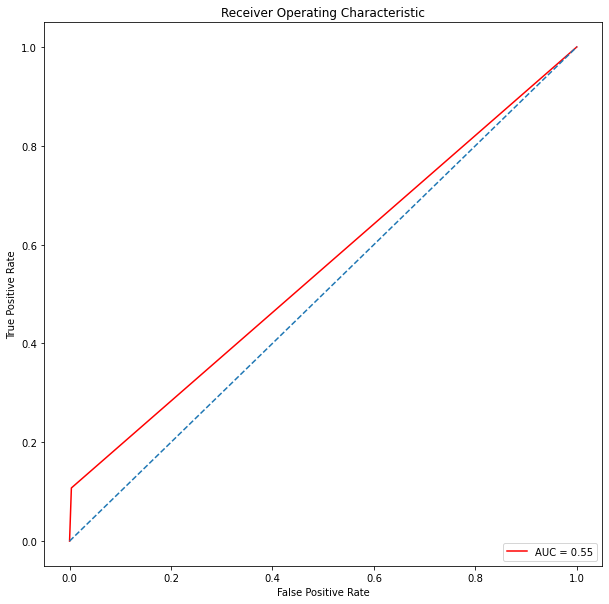

In [78]:
rfpred=model.predict(X_test)
print("Classification report \n {0}".format(classification_report(y_test, rfpred)))
roccurve(y_test, rfpred)

# **SVM WITH LINEAR KERNEL CLASSIFIER WITH INPUT FROM AUTO ENCODER**

In [51]:
svmclassifier = svm.LinearSVC(max_iter=2000)
svmclassifier.fit(X_train_enc, y_train1) 

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(max_iter=2000)

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.57      0.72     56653
           1       0.00      0.89      0.01        93

    accuracy                           0.57     56746
   macro avg       0.50      0.73      0.36     56746
weighted avg       1.00      0.57      0.72     56746



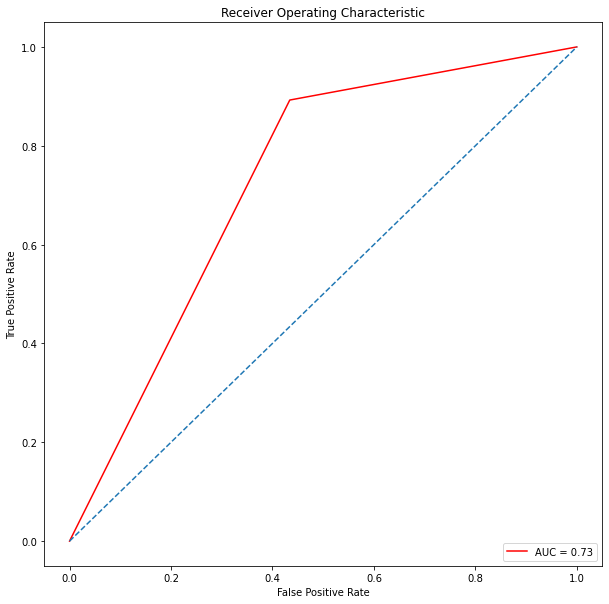

In [52]:
svmpred=svmclassifier.predict(X_test)
print("Classification report \n {0}".format(classification_report(y_test, svmpred)))
roccurve(y_test,svmpred)

# **UNDERSAMPLING DATASET**

In [63]:
df_train_all = data[0:150000] # We cut in two the original dataset
df_train_1 = df_train_all[df_train_all['Class'] == 1] # We seperate the data which are the frauds and the no frauds
df_train_0 = df_train_all[df_train_all['Class'] == 0]
print('In this dataset, we have ' + str(len(df_train_1)) +" frauds so we need to take a similar number of non-fraud")

df_sample=df_train_0.sample(len(df_train_1))
df_train = df_train_1.append(df_sample)
df_train = df_train.sample(frac=1) 
X_train_us = df_train.drop(['Class'],axis=1) 
y_train_us = df_train['Class'] 
X_train_us = np.asarray(X_train_us)
y_train_us = np.asarray(y_train_us)
X_train_noise_us= X_train_us

#ADDING NOISE
for i,x in enumerate(X_train_us):
    noise  = np.random.normal(0,0.02,[col])
    X_train_noise_us[i] += noise
    

df_test_all = data[150000:]
X_test_all = df_test_all.drop(['Class'],axis=1)
y_test_all = df_test_all['Class']
X_test_all = np.asarray(X_test_all)
y_test_all = np.asarray(y_test_all)

In this dataset, we have 284 frauds so we need to take a similar number of non-fraud


# **AUTO ENCODER FOR UNDER SAMPLE DATA**

In [64]:
# This returns a tensor
input_layer1 = Input(shape=(col, ))
encoder1 = Dense(22, activation="relu")(input_layer1)
encoder1 = Dense(15, activation="relu")(encoder1)
encoder1 = Dense(10, activation="relu")(encoder1)
decoder1 = Dense(15, activation='relu')(encoder1)
decoder1 = Dense(22, activation='relu')(decoder1)
decoder1 = Dense(29, activation='relu')(decoder1)

# This creates a model that includes
# the Input layer and four Dense layers
autoencoder1 = Model(inputs=input_layer1, outputs=decoder1)
autoencoder1.compile(optimizer=model_opt,loss=lossfunc)
autoencoder1.fit(x=X_train_noise_us,y=X_train_us,epochs=50,batch_size = 8)

Epoch 1/50
71/71 [==============================] - 0s 1ms/step - loss: 14.5596
Epoch 2/50
71/71 [==============================] - 0s 1ms/step - loss: 14.3930
Epoch 3/50
71/71 [==============================] - 0s 1ms/step - loss: 14.2972
Epoch 4/50
71/71 [==============================] - 0s 1ms/step - loss: 14.2259
Epoch 5/50
71/71 [==============================] - 0s 1ms/step - loss: 14.1663
Epoch 6/50
71/71 [==============================] - 0s 1ms/step - loss: 14.1147
Epoch 7/50
71/71 [==============================] - 0s 2ms/step - loss: 14.0680
Epoch 8/50
71/71 [==============================] - 0s 1ms/step - loss: 14.0266
Epoch 9/50
71/71 [==============================] - 0s 1ms/step - loss: 13.9891
Epoch 10/50
71/71 [==============================] - 0s 1ms/step - loss: 13.9537
Epoch 11/50
71/71 [==============================] - 0s 1ms/step - loss: 13.9191
Epoch 12/50
71/71 [==============================] - 0s 1ms/step - loss: 13.8879
Epoch 13/50
71/71 [==================

In [65]:
autoencoder1.trainable = False

# **NEURAL NETWORK CLASSIFIER WITH UNDER SAMPLE DATA**

In [66]:
classifier2 = Dense(22, activation="relu")(autoencoder1.output)
classifier2 = Dense(15, activation="relu")(classifier2)
classifier2 = Dense(10, activation="relu")(classifier2)
classifier2 = Dense(5, activation='relu')(classifier2)
classifier2 = Dense(2, activation='softmax')(classifier2)
classmodel_us = Model(inputs=autoencoder1.input,outputs=classifier2)
classmodel_us.compile(optimizer=keras.optimizers.Adam(0.01),
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
classmodel_us.fit(x=X_train_noise_us,y=y_train_us,epochs=40,batch_size = 4)


Epoch 1/40
142/142 [==============================] - 0s 1ms/step - loss: 0.3575 - accuracy: 0.8504
Epoch 2/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2658 - accuracy: 0.8908
Epoch 3/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2426 - accuracy: 0.9155
Epoch 4/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2323 - accuracy: 0.9067
Epoch 5/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2231 - accuracy: 0.9137
Epoch 6/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2278 - accuracy: 0.9173
Epoch 7/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2261 - accuracy: 0.9085
Epoch 8/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2133 - accuracy: 0.9155
Epoch 9/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2256 - accuracy: 0.9067
Epoch 10/40
142/142 [==============================] - 0s 1ms/step - loss: 0.2288 - accuracy: 0.9085

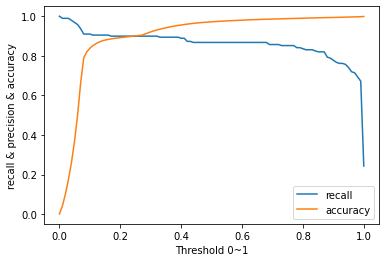

Classification report 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    133537
           1       0.06      0.87      0.11       189

    accuracy                           0.98    133726
   macro avg       0.53      0.92      0.55    133726
weighted avg       1.00      0.98      0.99    133726



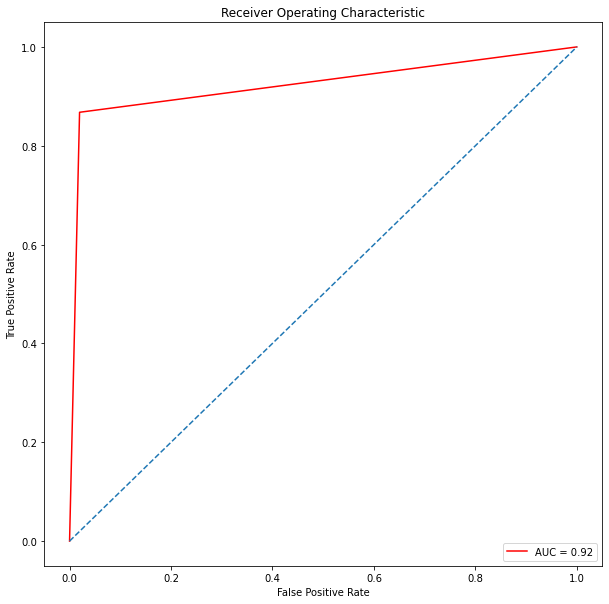

In [70]:
y_predus=classmodel_us.predict(X_test_all)
accrecallthrs(y_test_all,y_predus)
y_predus = onedarray1(0.6,y_predus)
print("Classification report \n {0}".format(classification_report(y_test_all, y_predus)))
roccurve(y_test_all, y_predus)